In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import torch
import torchvision
import torchvision.transforms.v2
import matplotlib.pyplot as plt

transform = torchvision.transforms.v2.Compose([
    # torchvision.transforms.v2.Resize((96, 96), antialias = True),
    torchvision.transforms.v2.Grayscale(),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    # torchvision.transforms.v2.Normalize(mean, std)
])

train = torchvision.datasets.ImageFolder("faces/training", transform = transform)
test = torchvision.datasets.ImageFolder("faces/testing", transform = transform)

In [60]:
import tqdm
import numpy

train_images = numpy.array([ numpy.array(item[0]).squeeze() for item in tqdm.tqdm(train) ])
train_labels = numpy.array([ item[1] for item in train ])

test_images = numpy.array([ numpy.array(item[0]).squeeze() for item in tqdm.tqdm(test) ])
test_labels = numpy.array([ item[1] for item in test ])

train_images.shape, test_images.shape

100%|██████████| 30/30 [00:00<00:00, 2934.72it/s]


((370, 112, 92), (30, 112, 92))

In [61]:
import os
import itertools

import typing

import tqdm
import numpy
import joblib
import gtda.images

import cvtda.utils
import cvtda.topology

def make_diagrams(
    binarizer,
    filtration,
    n_jobs: int = 1
) -> typing.Tuple[numpy.ndarray, numpy.ndarray]:
    dir = f"1/{str(filtration or 'None')}"
    if os.path.exists(f"{dir}/test_features.npy"):
        return 1, 2
    os.makedirs(dir, exist_ok = True)
    
    with joblib.parallel_backend("loky", inner_max_num_threads = n_jobs):
        train = train_images.copy()
        test = test_images.copy()

        if binarizer is not None:
            train = binarizer.fit_transform(train)
            test = binarizer.transform(test)
            
        if filtration is not None:
            train = filtration.fit_transform(train)
            test = filtration.transform(test)
        
        filtrations_to_diagrams = cvtda.topology.FiltrationsToDiagrams(verbose = False, n_jobs = n_jobs)
        train = filtrations_to_diagrams.fit_transform(train)
        test = filtrations_to_diagrams.transform(test)

    numpy.save(f"{dir}/train_diagrams.npy", train)
    numpy.save(f"{dir}/test_diagrams.npy", test)
    
    if len(train[0]) < 96:
        n_bins = 32
    elif len(train[0]) < 192:
        n_bins = 64
    else:
        n_bins = 128

    with joblib.parallel_backend("loky", inner_max_num_threads = n_jobs):
        digrams_to_features = cvtda.topology.DiagramsToFeatures(batch_size = 500, n_bins = n_bins, verbose = False, n_jobs = n_jobs)
        train = digrams_to_features.fit_transform(train)
        test = digrams_to_features.transform(test)

    numpy.save(f"{dir}/train_features.npy", train)
    numpy.save(f"{dir}/test_features.npy", test)

    return train, test

def process(binarizer_threshold: float) -> typing.Tuple[numpy.ndarray, numpy.ndarray]:
    centers = [ 5, 12, 18, 25 ]
    greyscale_to_filtrations = cvtda.topology.GreyscaleToFiltrations(
        n_jobs = 2,
        radial_filtration_centers = list(itertools.product(centers, centers))
    )
    diagrams = joblib.Parallel(return_as = 'generator', n_jobs = 8)(
        joblib.delayed(make_diagrams)(
            binarizer = gtda.images.Binarizer(threshold = binarizer_threshold, n_jobs = 1),
            filtration = filtration,
            n_jobs = 2
        )
        for filtration in greyscale_to_filtrations.filtrations_
    )
    for train, test in tqdm.tqdm(diagrams, total = len(greyscale_to_filtrations.filtrations_)):
        pass

    make_diagrams(
        binarizer = None,
        filtration = None,
        n_jobs = -1
    )

In [62]:
process(0.4)

100%|██████████| 24/24 [00:00<00:00, 140.10it/s]


In [63]:
import tqdm
import joblib
import torch
import gtda.diagrams
import torchph.nn.slayer

def process():
    def transform(diagram, dim):
        dim_filter = (diagram[:, 2] == dim)
        non_degenerate_filter = (diagram[:, 0] != diagram[:, 1])
        rotation = torchph.nn.slayer.UpperDiagonalThresholdedLogTransform(0.05)
        return rotation(diagram[dim_filter & non_degenerate_filter][:, 0:2])

    train_data = [ ]
    test_data = [ ]
    for filtration in tqdm.tqdm(os.listdir(f"1")):
        for dim in [ 0, 1 ]:
                dir = f"1/{filtration}"
                train_diagrams = numpy.load(f"{dir}/train_diagrams.npy")
                test_diagrams = numpy.load(f"{dir}/test_diagrams.npy")

                scaler = gtda.diagrams.Scaler()
                train_diagrams = scaler.fit_transform(train_diagrams)
                test_diagrams = scaler.transform(test_diagrams)
                
                # filtering = gtda.diagrams.Filtering()
                # train_diagrams = filtering.fit_transform(train_diagrams)
                # test_diagrams = filtering.transform(test_diagrams)
                
                train_diagrams = torch.tensor(train_diagrams, dtype = torch.float32)
                test_diagrams = torch.tensor(test_diagrams, dtype = torch.float32)

                diagrams_train = joblib.Parallel(n_jobs = 1)(joblib.delayed(transform)(diagram, dim) for diagram in train_diagrams)
                diagrams, non_dummy_points, _, _ = torchph.nn.slayer.prepare_batch(diagrams_train)
                train_data.append(diagrams)
                train_data.append(non_dummy_points)
                
                diagrams_test = joblib.Parallel(n_jobs = 1)(joblib.delayed(transform)(diagram, dim) for diagram in test_diagrams)
                diagrams, non_dummy_points, _, _ = torchph.nn.slayer.prepare_batch(diagrams_test)
                test_data.append(diagrams)
                test_data.append(non_dummy_points)
    return train_data, test_data

train_diagrams, test_diagrams = process()
 
print(len(train_diagrams), train_diagrams[0].shape, train_diagrams[1].shape)
print(len(test_diagrams), test_diagrams[0].shape, test_diagrams[1].shape)

100%|██████████| 25/25 [00:03<00:00,  6.66it/s]

100 torch.Size([370, 102, 2]) torch.Size([370, 102])
100 torch.Size([30, 66, 2]) torch.Size([30, 66])


In [64]:
train_labels = torch.tensor(train_labels, dtype = torch.long)
test_labels = torch.tensor(test_labels, dtype = torch.long)

(19, 1)

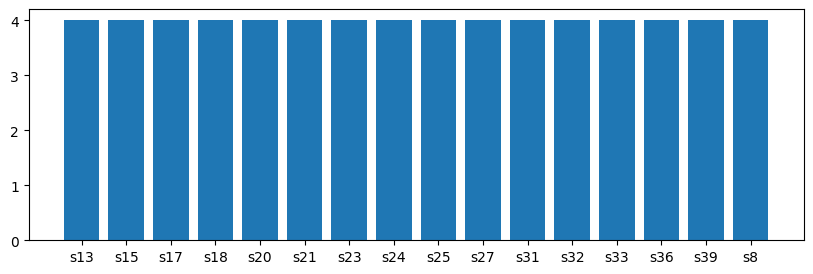

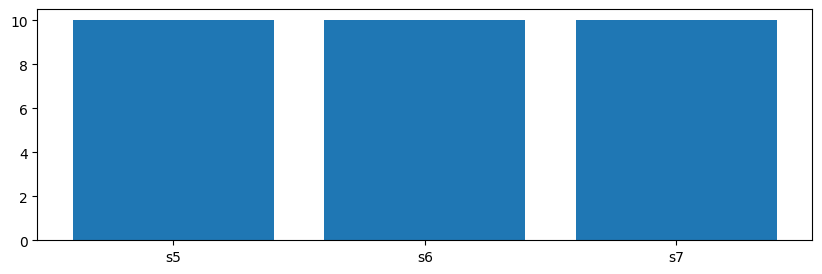

In [65]:
import pytorch_metric_learning.samplers

def show_class_distribtion(labels, classes):
    plt.figure(figsize = (10, 3))
    x, counts = labels.unique(return_counts = True)
    plt.bar(numpy.array(classes)[x], height = counts)

N_EPOCHS = 25
LENGTH_BEFORE_NEW_ITER = 1280
train_mpc_sampler = pytorch_metric_learning.samplers.MPerClassSampler(labels = train_labels, m = 4, length_before_new_iter = LENGTH_BEFORE_NEW_ITER)
train_set = torch.utils.data.TensorDataset(train_labels, *train_diagrams)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, sampler = train_mpc_sampler)
show_class_distribtion(next(iter(train_loader))[0], train.classes)


test_set = torch.utils.data.TensorDataset(test_labels, *test_diagrams)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = len(test_set))
show_class_distribtion(next(iter(test_loader))[0], test.classes)

len(train_loader), len(test_loader)

In [66]:
import torch

device = torch.device('cuda')

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.n_elements = 128
        self.n_channels = 50
        self.slayers = [
            torchph.nn.slayer.SLayerExponential(self.n_elements).to(device)
            for _ in range(self.n_channels)
        ]

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.2), torch.nn.Linear(self.n_channels * self.n_elements, 1024), torch.nn.BatchNorm1d(1024), torch.nn.ReLU(),
            torch.nn.Dropout(0.1), torch.nn.Linear(1024, 512), torch.nn.BatchNorm1d(512), torch.nn.ReLU(),
            torch.nn.Linear(512, 256)
        ).to(device)
    
    def forward(self, args):
        features = [ ]
        for i in range(0, len(args), 2):
            slayer_args = (args[i].to(device), args[i + 1].to(device), args[i].shape[1], len(args[i]))
            features.append(self.slayers[i // 2](slayer_args))
        return self.classifier(torch.cat(features, dim = 1))
    
model = Net()

In [67]:
MARGIN = 0.5 # Standard value in PyTorch TripletMarginLoss, should be good

In [68]:
import pytorch_metric_learning.miners

train_miner = pytorch_metric_learning.miners.TripletMarginMiner(margin = MARGIN, type_of_triplets = "all")

labels, *images = next(iter(train_loader))
embeddings = model(images)
print(embeddings.shape)

indices = train_miner(embeddings, labels)
print(len(indices), indices[0].shape, indices[1].shape, indices[2].shape)

torch.Size([64, 256])
3 torch.Size([11379]) torch.Size([11379]) torch.Size([11379])


In [69]:
import pytorch_metric_learning.losses

criterion = pytorch_metric_learning.losses.TripletMarginLoss(margin = MARGIN)
loss = criterion(embeddings, labels, indices)
print(loss)

tensor(0.3968, device='cuda:0', grad_fn=<MeanBackward0>)


In [70]:
import pytorch_metric_learning.utils.accuracy_calculator

device = torch.device('cuda')

metrics = pytorch_metric_learning.utils.accuracy_calculator.AccuracyCalculator()
def validate(model: torch.nn.Module) -> dict:
    with torch.no_grad():
        targets, *images = next(iter(test_loader))
        model = model.to(device)
        model.eval()
        embeddings = model(images)
        return metrics.get_accuracy(embeddings, targets.to(device))

validate(model)

{'AMI': 0.5659344147055957,
 'NMI': 0.5957668744210505,
 'mean_average_precision': 0.8858484752516401,
 'mean_average_precision_at_r': 0.7801293356848913,
 'mean_reciprocal_rank': 1.0,
 'precision_at_1': 1.0,
 'r_precision': 0.7814814814814814}

In [71]:
def train(model: torch.nn.Module, n_epochs: int) -> None:
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = 7e-5)
    for epoch in range(n_epochs):
        sum_loss = 0
        for (targets, *images) in tqdm.tqdm(train_loader, desc = 'Epoch {}'.format(epoch + 1)):
            if len(targets) == 0:
                continue
            model.train() # Enter train mode
            optimizer.zero_grad() # Zero gradients
            embeddings = model(images)
            indices = train_miner(embeddings, targets)
            loss = criterion(embeddings, targets.to(device), indices)
            loss.backward() # Calculate gradients
            optimizer.step() # Update weights
            sum_loss += loss.item()
        train_loss = sum_loss / len(train_loader)
        metrics = validate(model)
        mean_avg_pr = metrics['mean_average_precision']
        AMI = metrics['AMI']
        NMI = metrics['NMI']
        print(f"Train loss: {train_loss:.5f}, Test MAP: {mean_avg_pr:.5f}, Test AMI: {AMI:.5f}, Test NMI: {NMI:.5f}")

train(model, N_EPOCHS)

Epoch 1: 100%|██████████| 19/19 [00:04<00:00,  3.94it/s]


Train loss: 0.36261, Test MAP: 0.92042, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 2: 100%|██████████| 19/19 [00:04<00:00,  4.11it/s]


Train loss: 0.34608, Test MAP: 0.98909, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 3: 100%|██████████| 19/19 [00:04<00:00,  4.16it/s]


Train loss: 0.32768, Test MAP: 0.99401, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 4: 100%|██████████| 19/19 [00:04<00:00,  4.28it/s]


Train loss: 0.32242, Test MAP: 0.99553, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 5: 100%|██████████| 19/19 [00:04<00:00,  4.38it/s]


Train loss: 0.31428, Test MAP: 0.99745, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 6: 100%|██████████| 19/19 [00:04<00:00,  4.26it/s]


Train loss: 0.30399, Test MAP: 0.99854, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 7: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s]


Train loss: 0.29484, Test MAP: 0.98765, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 8: 100%|██████████| 19/19 [00:04<00:00,  4.42it/s]


Train loss: 0.29196, Test MAP: 0.99870, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 9: 100%|██████████| 19/19 [00:04<00:00,  3.94it/s]


Train loss: 0.29189, Test MAP: 0.99348, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 10: 100%|██████████| 19/19 [00:04<00:00,  4.03it/s]


Train loss: 0.28114, Test MAP: 0.99745, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 11: 100%|██████████| 19/19 [00:04<00:00,  4.18it/s]


Train loss: 0.26687, Test MAP: 0.99752, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 12: 100%|██████████| 19/19 [00:04<00:00,  4.37it/s]


Train loss: 0.26589, Test MAP: 0.99665, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 13: 100%|██████████| 19/19 [00:04<00:00,  4.36it/s]


Train loss: 0.26808, Test MAP: 0.99800, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 14: 100%|██████████| 19/19 [00:04<00:00,  4.16it/s]


Train loss: 0.24958, Test MAP: 0.99729, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 15: 100%|██████████| 19/19 [00:04<00:00,  4.28it/s]


Train loss: 0.25463, Test MAP: 0.99673, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 16: 100%|██████████| 19/19 [00:04<00:00,  4.20it/s]


Train loss: 0.25960, Test MAP: 0.99445, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 17: 100%|██████████| 19/19 [00:04<00:00,  4.30it/s]


Train loss: 0.24722, Test MAP: 0.99711, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 18: 100%|██████████| 19/19 [00:04<00:00,  4.23it/s]


Train loss: 0.24274, Test MAP: 0.99774, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 19: 100%|██████████| 19/19 [00:04<00:00,  4.23it/s]


Train loss: 0.23354, Test MAP: 0.99737, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 20: 100%|██████████| 19/19 [00:04<00:00,  4.31it/s]


Train loss: 0.22730, Test MAP: 0.99733, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 21: 100%|██████████| 19/19 [00:04<00:00,  4.28it/s]


Train loss: 0.23612, Test MAP: 0.99636, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 22: 100%|██████████| 19/19 [00:04<00:00,  4.16it/s]


Train loss: 0.22848, Test MAP: 0.99460, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 23: 100%|██████████| 19/19 [00:04<00:00,  4.29it/s]


Train loss: 0.20997, Test MAP: 0.99404, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 24: 100%|██████████| 19/19 [00:04<00:00,  4.22it/s]


Train loss: 0.20419, Test MAP: 0.99854, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 25: 100%|██████████| 19/19 [00:04<00:00,  4.36it/s]

Train loss: 0.20675, Test MAP: 0.99476, Test AMI: 1.00000, Test NMI: 1.00000


In [72]:
model.eval()
validate(model)

{'AMI': 1.0,
 'NMI': 1.0,
 'mean_average_precision': 0.9947638780972115,
 'mean_average_precision_at_r': 0.9814814814814815,
 'mean_reciprocal_rank': 1.0,
 'precision_at_1': 1.0,
 'r_precision': 0.9814814814814815}

In [73]:
with torch.no_grad():
    test_embeddings = model(next(iter(test_loader))[1:])

In [74]:
import pandas

matrix = [ [ "-1" ] * len(test_labels) for i in range(len(test_labels)) ]
for i, (emb1, label1) in enumerate(zip(test_embeddings, test_labels)):
    for j, (emb2, label2) in enumerate(zip(test_embeddings, test_labels)):
        euc_dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
        matrix[i][j] = "{0:.2f}".format(euc_dist)

pandas.options.display.max_columns = 30
df = pandas.DataFrame(matrix, columns = test_labels.tolist())
df.index = test_labels.tolist()
df

,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2
0,0.00,4.96,1.67,2.36,0.98,4.53,4.24,1.62,5.31,4.96,8.02,9.15,9.60,7.06,12.70,7.37,10.37,11.17,12.45,12.46,15.78,9.96,12.82,13.48,12.54,11.54,13.96,15.19,17.40,16.32
0,4.96,0.00,4.53,4.94,5.30,1.90,1.22,4.41,1.95,1.36,7.66,7.98,8.48,7.39,11.09,6.73,9.04,9.44,10.75,11.10,16.96,11.07,14.50,14.90,13.19,12.41,15.57,16.54,18.48,17.22
0,1.67,4.53,0.00,1.85,1.71,4.51,3.80,1.33,4.66,4.75,7.82,9.06,9.25,6.90,12.45,7.17,10.06,10.84,12.06,12.05,14.77,9.00,12.02,12.51,11.63,10.59,13.05,14.18,16.35,15.31
0,2.36,4.94,1.85,0.00,2.82,4.56,4.02,1.65,4.61,5.22,9.27,10.35,10.66,8.26,13.65,8.63,11.46,12.12,13.40,13.27,15.07,9.75,12.27,12.91,12.49,11.42,13.41,14.39,16.62,15.41
0,0.98,5.30,1.71,2.82,0.00,5.03,4.66,1.81,5.80,5.41,7.77,9.06,9.34,6.87,12.58,7.15,10.13,11.04,12.20,12.32,15.47,9.60,12.59,13.15,12.19,11.14,13.62,14.90,17.07,16.14
0,4.53,1.90,4.51,4.56,5.03,0.00,1.75,4.10,2.74,2.15,8.21,8.57,9.19,7.81,11.74,7.37,9.81,10.25,11.56,11.89,17.32,11.51,14.71,15.25,13.83,12.94,15.86,16.84,18.82,17.54
0,4.24,1.22,3.80,4.02,4.66,1.75,0.00,3.65,1.72,1.76,7.93,8.38,8.95,7.37,11.66,7.05,9.58,10.01,11.40,11.47,16.38,10.64,13.81,14.28,12.88,12.06,14.96,15.90,17.95,16.60
0,1.62,4.41,1.33,1.65,1.81,4.10,3.65,0.00,4.68,4.78,8.52,9.67,9.90,7.73,13.04,7.86,10.69,11.48,12.64,12.84,15.63,9.99,12.88,13.38,12.66,11.57,13.92,15.00,17.16,16.13
0,5.31,1.95,4.66,4.61,5.80,2.74,1.72,4.68,0.00,2.15,8.44,8.70,9.30,7.87,11.70,7.60,9.88,10.10,11.58,11.45,16.39,10.82,13.92,14.41,12.99,12.27,15.13,15.89,17.94,16.38
0,4.96,1.36,4.75,5.22,5.41,2.15,1.76,4.78,2.15,0.00,7.16,7.27,8.11,6.74,10.55,6.23,8.64,8.92,10.46,10.49,17.07,11.07,14.45,14.98,13.09,12.43,15.67,16.65,18.67,17.21


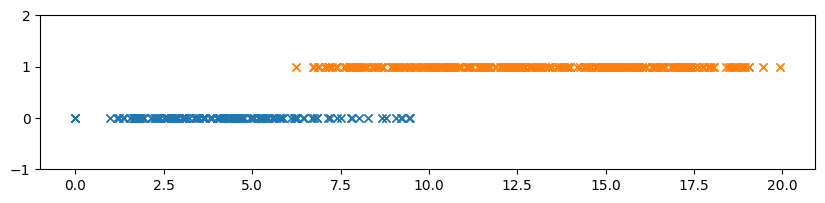

In [75]:

correct_dists = [ ]
incorrect_dists = [ ]
for i, (emb1, label1) in enumerate(zip(test_embeddings, test_labels)):
    for j, (emb2, label2) in enumerate(zip(test_embeddings, test_labels)):
        euc_dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
        if label1 == label2: correct_dists.append(euc_dist)
        else: incorrect_dists.append(euc_dist)

plt.figure(figsize = (10, 2))
plt.ylim(-1, 2)
plt.plot(correct_dists, numpy.zeros_like(correct_dists), 'x')
plt.plot(incorrect_dists, numpy.ones_like(incorrect_dists), 'x')

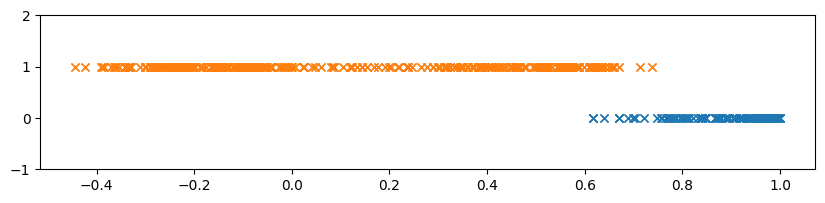

In [76]:
correct_dists = [ ]
incorrect_dists = [ ]
for i, (emb1, label1) in enumerate(zip(test_embeddings, test_labels)):
    for j, (emb2, label2) in enumerate(zip(test_embeddings, test_labels)):
        cos_dist = torch.nn.functional.cosine_similarity(emb1, emb2, dim = 0).item()
        if label1 == label2: correct_dists.append(cos_dist)
        else: incorrect_dists.append(cos_dist)

plt.figure(figsize = (10, 2))
plt.ylim(-1, 2)
plt.plot(correct_dists, numpy.zeros_like(correct_dists), 'x')
plt.plot(incorrect_dists, numpy.ones_like(incorrect_dists), 'x')